# <center>Recurrent Neural Networks</center>
## <center>Inclass Project 3 - MA4144</center>

This project contains 10 tasks/questions to be completed, some require written answers. Open a markdown cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle**.

***

## Outline of the project

The aim of the project is to build a RNN model to suggest autocompletion of half typed words. You may have seen this in many day today applications; typing an email, a text message etc. For example, suppose you type in the four letter "univ", the application may suggest you to autocomplete it by "university".

![Autocomplete](https://d33v4339jhl8k0.cloudfront.net/docs/assets/5c12e83004286304a71d5b72/images/66d0cb106eb51e63b8f9fbc6/file-gBQe016VYt.gif)

We will train a RNN to suggest possible autocompletes given $3$ - $4$ starting letters. That is if we input a string "univ" hopefully we expect to see an output like "university", "universal" etc.

For this we will use a text file (wordlist.txt) containing 10,000 common English words (you'll find the file on the moodle link). The list of words will be the "**vocabulary**" for our model.

We will use the Python **torch library** to implement our autocomplete model. 

***


Use the below cell to use any include any imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

## Section 1: Preparing the vocabulary

In [3]:
WORD_SIZE = 13

**Q1.** In the following cell provide code to load the text file (each word is in a newline), then extract the words (in lowercase) into a list.

For practical reasons of training the model we will only use words that are longer that $3$ letters and that have a maximum length of WORD_SIZE (this will be a constant we set at the beginning - you can change this and experiment with different WORD_SIZEs). As seen above it is set to $13$.

So out of the extracted list of words filter out those words that match our criteria on word length.

To train our model it is convenient to have words/strings of equal length. We will choose to convert every word to length of WORD_SIZE, by adding underscores to the end of the word if it is initially shorter than WORD_SIZE. For example, we will convert the word "university" (word length 10) into "university___" (wordlength 13). In your code include this conversion as well.

Store the processed WORD_SIZE lengthed strings in a list called vocab.

In [4]:
file_path = "wordlist.txt"
min_word_length = 3

def prepare_vocabulary(file_path, word_size, min_word_length):
    with open(file_path, 'r') as file:
        words = file.readlines()

    vocab = [word.strip().lower().ljust(word_size, '_')
             for word in words
             if min_word_length < len(word.strip()) <= word_size]

    return vocab

vocab = prepare_vocabulary(file_path, WORD_SIZE, min_word_length)
print(vocab[:10])


['aaron________', 'abandoned____', 'aberdeen_____', 'abilities____', 'ability______', 'able_________', 'aboriginal___', 'abortion_____', 'about________', 'above________']


<font color='blue'>In the above explanation it was mentioned "for practical reasons of training the model we will only use words that are longer that $3$ letters and that have a certain maximum length". In your opinion what could be those practical? Will hit help to build a better model?</font>

**Answer** (to write answers edit this cell)

<span style="color: green;">Yes, the claim is valid. Using ordinal encoding assigns arbitrary numerical values to letters, which can misrepresent relationships between them. Embedding layers offer a better alternative by mapping letters into vectors, allowing the model to learn meaningful relationships based on context. Limiting word length also helps reduce overfitting on rare long words and lowers the number of parameters, improving the model's efficiency and performance.</span>


**Q2** To input words into the model, we will need to convert each letter/character into a number. as we have seen above, the only characters in our list vocab will be the underscore and lowercase english letters. so we will convert these $27$ characters into numbers as follows: underscore -> $0$, 'a' -> $1$, 'b' -> $2$, $\cdots$, 'z' -> $26$. In the following cell,

(i) Implement a method called char_to_num, that takes in a valid character and outputs its numerical assignment.

(ii) Implement a method called num_to_char, that takes in a valid number from $0$ to $26$ and outputs the corresponding character.

(iii) Implement a method called word_to_numlist, that takes in a word from our vocabulary and outputs a (torch) tensor of numbers that corresponds to each character in the word in that order. For example: the word "united_______" will be converted to tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]). You are encouraged to use your char_to_num method for this.

(iv) Implement a method called numlist_to_word, that does the opposite of the above described word_to_numlist, given a tensor of numbers from $0$ to $26$, outputs the corresponding word. You are encouraged to use your  num_to_char method for this.

Note: As mentioned since we are using the torch library we will be using tensors instead of the usual python lists or numpy arrays. Tensors are the list equivalent in torch. Torch models only accept tensors as input and they output tensors.

In [5]:
def char_to_num(char):
    if char == '_':
        num = 0
    else:
        num = ord(char) - ord('a') + 1
    return num

def num_to_char(num):
    if num == 0:
        char = '_'
    else:
        char = chr(num + ord('a') - 1)
    return char

def word_to_numlist(word):
    num_list = []
    for char in word:
        num_list.append(char_to_num(char))

    return torch.tensor(num_list)

def numlist_to_word(numlist):
    char_list = [num_to_char(num.item()) for num in numlist]
    word = ''.join(char_list)
    
    return word


<font color='blue'>We convert letter into just numbers based on their aphabetical order, I claim that it is a very bad way to encode data such as letters to be fed into learning models, please write your explanation to or against my claim. If you are searching for reasons, the keyword 'categorical data' may be useful. Although the letters in our case are not treated as categorical data, the same reasons as for categorical data is applicable. Even if my claim is valid, at the end it won't matter due to something called "embedding layers" that we will use in our model. What is an embedding layer? What is it's purpose? Explain.</font>

**Answer** (to write answers edit this cell)

<span style="color: green;">The claim is valid. Using ordinal encoding to convert letters to numbers loses semantic relationships, as it creates an artificial order among letters that doesn't reflect their actual associations. Embedding layers solve this problem by transforming discrete inputs into dense vectors, capturing meaningful relationships between characters in a higher-dimensional space. This approach maintains the semantic meaning of the inputs and allows the model to learn patterns effectively. By positioning similar letters closer together, embedding layers avoid ordinal bias and enhance the model's understanding of context, leading to more accurate representations.</span>


## Section 2: Implementing the Autocomplete model

We will implement a RNN model based on LSTM. The [video tutorial](https://www.youtube.com/watch?v=tL5puCeDr-o) will be useful. Our model will be only one hidden layer, but feel free to sophisticate with more layers after the project for your own experiments.

Our model will contain all the training and prediction methods as single package in a class (autocompleteModel) we will define and implement below.

In [6]:
LEARNING_RATE = 0.005

In [7]:
class autocompleteModel(nn.Module):

    #Constructor
    def __init__(self, alphabet_size, embed_dim, hidden_size, num_layers):
        super().__init__()

        #Set the input parameters to self parameters
        self.alphabet_size = alphabet_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #Initialize the layers in the model:
        #1 embedding layer, 1 - LSTM cell (hidden layer), 1 fully connected layer with linear activation
        self.embedding = nn.Embedding(alphabet_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, alphabet_size)

    #Feedforward
    def forward(self, character, hidden_state, cell_state):

        #Perform feedforward in order
        embedded = self.embedding(character)
        lstm_out, (hidden_state, cell_state) = self.lstm(embedded.unsqueeze(0), (hidden_state, cell_state))


        output = self.fc(lstm_out.squeeze(0))

        return output, hidden_state, cell_state


    #Intialize the first hidden state and cell state (for the start of a word) as zero tensors of required length.
    def initial_state(self):

        batch_size=1
        device=torch.device('cpu')
        
        
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        return (h0, c0)



    #Train the model in epochs given the vocab, the training will be fed in batches of batch_size
    def trainModel(self, vocab, epochs = 5, batch_size = 128):

        #Convert the model into train mode
        self.train()

        #Set the optimizer (ADAM), you may need to provide the model parameters  and learning rate
        optimizer = torch.optim.Adam(self.parameters(),lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()

        #Keep a log of the loss at the end of each training cycle.
        loss_log = []

        for e in range(epochs):


            random.shuffle(vocab)
            num_iter = len(vocab) // batch_size
            
            for i in range(num_iter):
                vocab_batch = vocab[i * batch_size:(i+1) * batch_size]
                optimizer.zero_grad()
                total_loss = 0

                for word in vocab_batch:

                    h0, c0 = self.initial_state()

                    input_tensor = word_to_numlist(word)[:-1]
                    target_tensor = word_to_numlist(word)[1:]

                    #Loop through each character (as a number) in the word
                    for c in range(WORD_SIZE - 1):
                        output, h0, c0 = self.forward(input_tensor[c].unsqueeze(0), h0, c0)
                        loss = criterion(output, target_tensor[c].unsqueeze(0))

                        total_loss += loss

                total_loss = total_loss / (batch_size * (WORD_SIZE - 1))
                total_loss.backward()

                optimizer.step()

                loss_log.append(loss.item())

            print("Epoch: ", e)

        plt.plot(loss_log)
        plt.title('Graph of Loss vs Epochs')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.show()

    #Perform autocmplete given a sample of strings (typically 3-5 starting letters)
    def autocomplete(self, sample):

        #Convert the model into evaluation mode
        self.eval()

        completed_list = []
        softmax_function = torch.nn.Softmax(dim=1)
        
        for literal in sample:
            h0, c0 = self.initial_state()
            input_sequence = word_to_numlist(literal)
            generated_word = literal
        
            for j in range(len(input_sequence)):
                output, h0, c0 = self.forward(input_sequence[j].unsqueeze(0), h0, c0)

            while len(generated_word) < WORD_SIZE:
                probabilities = softmax_function(output)
                next_char_num = int(torch.multinomial(probabilities, 1))
                next_char = num_to_char(next_char_num)
            
                if next_char == '_':
                    break
            
                generated_word = generated_word + next_char
                input_sequence = torch.tensor([next_char_num], device=output.device)
                output, h0, c0 = self.forward(input_sequence, h0, c0)


            completed_list.append(generated_word)
        
        return completed_list


## Section 3: Using and evaluating the model

(i) Feel free to initialize a autocompleteModel using different embedding dimensions and hidden layer sizes. Use different learning rates, epochs, batch sizes. Train the best model you can. Show the loss curves in you answers.

(ii) Evaluate it on different samples of partially filled in words. Eg: ["univ", "math", "neur", "engin"] etc. Please show outputs for different samples.

<font color='blue'>Comment on the results. Is it successful? Do you see familiar substrings in the generated tesxt such as "tion", "ing", "able" etc. What are your suggestions to improve the model?</font>

**Answer** (to write answers edit this cell)

<span style="color: green;">The model shows some success in completing words, as it generates familiar patterns like "ity" and "ed". However, it sometimes produces incorrect completions, indicating that while it learns common substrings, it struggles with more complex predictions. To improve the model, enhancing the training data, applying regularization techniques, and adjusting the softmax temperature could help.</span>

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9


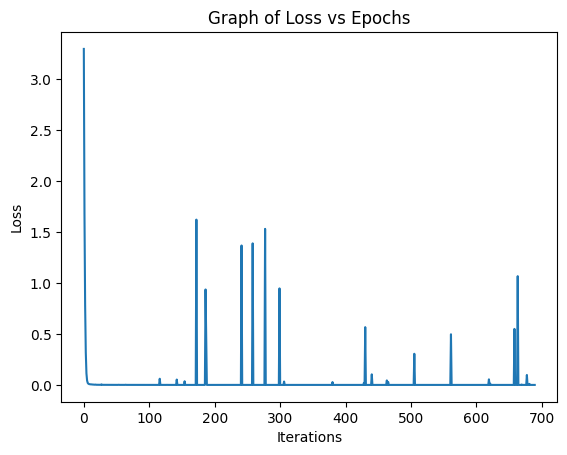

In [8]:
model = autocompleteModel(alphabet_size = 27, embed_dim = 128, hidden_size = 128, num_layers = 1)
model.trainModel(vocab=vocab, epochs=10)

In [36]:
words_sample = ["univ", "math", "neur", "engin"]
output_words = model.autocomplete(words_sample)

print(output_words)

['university', 'math', 'neury', 'engined']
